<a href="https://colab.research.google.com/github/nahanrahman/VAE_DogImages/blob/main/VAE_DogImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU is available')
else:
    print('GPU is NOT available')




GPU is available


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os


In [5]:
image_folder = '/content/drive/My Drive/ColabNotebooks/dataset_dogImages/'

In [6]:
def load_and_preprocess_image(path):
  img = tf.keras.preprocessing.image.load_img(path, target_size=(64, 64))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = img / 255.0 # Normalize to [0, 1]
  return img

In [7]:
image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith('.jpg')]
images = np.array([load_and_preprocess_image(path) for path in image_paths])

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [10]:
split_index = int(0.8 * len(images))
train_images = images[:split_index]
test_images =  images[split_index:]

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, backend as K
latent_dim = 128

encoder_inputs = layers.Input(shape=(64, 64, 3))
x = layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(encoder_inputs)
x = layers.Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)



In [12]:
def sampling(args):
  z_mean, z_log_var = args
  batch = tf.shape(z_mean)[0]
  dim = tf.shape(z_mean)[1]
  epsilon = K.random_normal(shape=(batch, dim))
  return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [14]:
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

In [15]:
sample_inputs = tf.ones((1, 64, 64, 3)) # Sample input
sample_z = encoder(sample_inputs)[2]
print(f"Shape of the latent vector z: {sample_z.shape}")

Shape of the latent vector z: (1, 128)


In [16]:
latent_dim = 128
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 256, activation='relu')(latent_inputs)
x = layers.Reshape((8, 8, 256))(x)
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder_outputs = x
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name='decoder')

In [17]:
latent_dim = 128
outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, outputs, name='vae')

In [18]:
def vae_loss(inputs, outputs, z_mean, z_log_var):
  inputs_flattened = K.flatten(inputs)
  outputs_flattened = K.flatten(outputs)
  reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs_flattened, outputs_flattened)
  reconstruction_loss = K.sum(reconstruction_loss)
  kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  return K.mean(reconstruction_loss + kl_loss)

In [19]:
optimizer = tf.keras.optimizers.Adam()

In [29]:
def train_step(inputs):
  with tf.GradientTape() as tape:
    z_mean, z_log_var, z = encoder(inputs)
    outputs = decoder(z)
    loss = vae_loss(inputs, outputs, z_mean, z_log_var)
  grads = tape.gradient(loss, vae.trainable_weights)
  optimizer.apply_gradients(zip(grads, vae.trainable_weights))
  return loss

In [21]:
epochs = 50
batch_size = 32
num_batches = len(train_images) // batch_size
num_val_batches = len(test_images) //batch_size


In [22]:
augmented_data = datagen.flow(train_images, batch_size=batch_size)


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = "checkpoints/vae_checkpoint.weights.h5"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss')


In [24]:
best_val_loss = float('inf')
patience_counter = 0

In [25]:

@tf.function
def validation_step(batch):
    reconstruction, mean, logvar = vae(batch, training=False)
    recon_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(batch, reconstruction))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    total_loss = recon_loss + kl_loss

    return total_loss


In [26]:
def call(self, inputs, training=False):
    mean, logvar = self.encoder(inputs)
    z = self.sampling([mean, logvar])
    reconstruction = self.decoder(z)
    return reconstruction, mean, logvar


In [30]:
for epoch in range(epochs):
  print(f"Epoch {epoch+1}/{epochs}")
  for i in range(num_batches):
    batch = train_images[i*batch_size:(i+1)*batch_size]
    #augmented_batch = next(datagen.flow(batch, batch_size=batch_size))
    loss = train_step(batch)
    if i % 100 == 0:
      print(f"Batch {i}, Loss: {loss.numpy()}")



Epoch 1/50
Batch 0, Loss: 0.809073269367218
Batch 100, Loss: 0.6807827949523926
Epoch 2/50
Batch 0, Loss: 0.681154727935791
Batch 100, Loss: 0.6810462474822998
Epoch 3/50
Batch 0, Loss: 0.6807512044906616
Batch 100, Loss: 0.6810401678085327
Epoch 4/50
Batch 0, Loss: 0.6806821823120117
Batch 100, Loss: 0.6810346841812134
Epoch 5/50
Batch 0, Loss: 0.680628776550293
Batch 100, Loss: 0.6809981465339661
Epoch 6/50
Batch 0, Loss: 0.6806356906890869
Batch 100, Loss: 0.6809417009353638
Epoch 7/50
Batch 0, Loss: 0.68065345287323
Batch 100, Loss: 0.6807198524475098
Epoch 8/50
Batch 0, Loss: 0.6806415319442749
Batch 100, Loss: 0.6807249784469604
Epoch 9/50
Batch 0, Loss: 0.6807066202163696
Batch 100, Loss: 0.6807096004486084
Epoch 10/50
Batch 0, Loss: 0.6810921430587769
Batch 100, Loss: 0.6804853677749634
Epoch 11/50
Batch 0, Loss: 0.6809472441673279
Batch 100, Loss: 0.6805464029312134
Epoch 12/50
Batch 0, Loss: 0.6806690692901611
Batch 100, Loss: 0.6801761984825134
Epoch 13/50
Batch 0, Loss: 0.6

In [31]:
import matplotlib.pyplot as plt

In [32]:
n = 10
test_sample = test_images[:n]

In [33]:
z_mean, _, z = encoder.predict(test_sample)
reconstructed_images = decoder.predict(z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


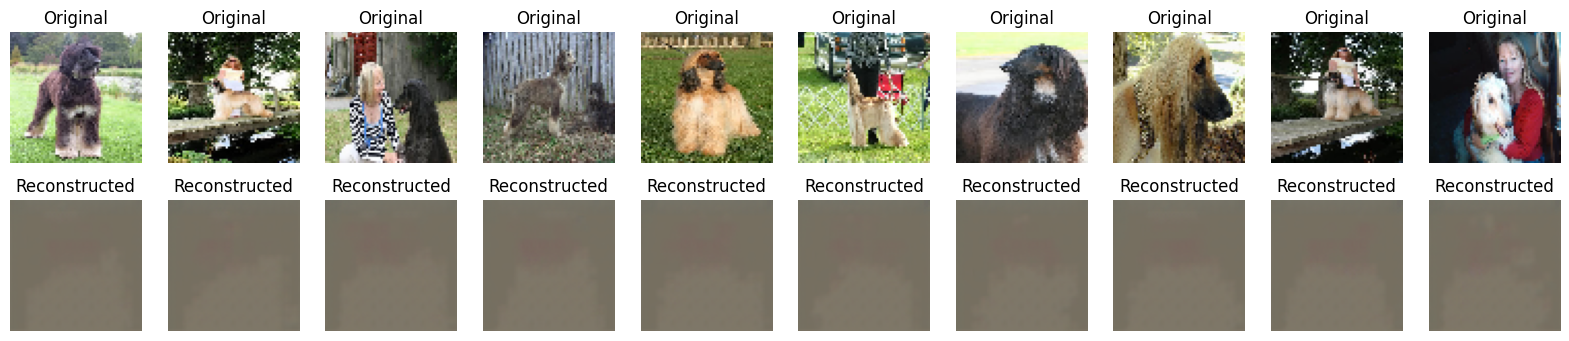

In [35]:
plt.figure(figsize=(20, 4))
for i in range(n):
  # Display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test_sample[i])
  plt.title("Original")
  plt.axis("off")

  # Display reconstruction
  ax = plt.subplot(2, n, i + n + 1)
  plt.imshow(reconstructed_images[i])
  plt.title("Reconstructed")
  plt.axis("off")
plt.show()